# Introducción

## Autores

Juan Pablo Jaramillo Tobon CC 1216727112

Daniel Alejandro Higuita Usuga CC 1152706601

## Dataset

El conjunto de datos de polaridad de reseñas de Amazon se construye tomando las puntuaciones de reseñas 1 y 2 como negativas, y 4 y 5 como positivas. Se ignoran las muestras de puntuación 3. En el conjunto de datos, la clase 1 es negativa y la clase 2 es positiva.

Los CSV contienen polaridad, título y texto. Estas 3 columnas en ellos corresponden al índice de clase (1 o 2), título de la reseña y texto de la reseña.

 * Polaridad: 1 para negativo y 2 para positivo.
 * título - título de reseña
 * texto - cuerpo de reseña

https://www.kaggle.com/datasets/sohaibanwaar1203/taxidemandfarepredictiondataset

## Objetivo

Creación de un modelo entrenado a partir de reseñas en inglés de Amazon que permita la clasificacón de reseñas de productos

# Dependencias

## Environment Variables

In [6]:
# Carga de env variables 
# ==============================================================================
import yaml
with open('config.yaml') as f:
    env_vars = yaml.safe_load(f)

## Instalación de Dependencias

In [7]:
if env_vars['install_dependencies']:
    %pip install -r requirements.txt

## Librerias

In [10]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import re
import string

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Preprocesado y modelado
# ==============================================================================
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from functools import reduce

nltk.download('stopwords')
nltk.download('punkt')


from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


from sklearn.metrics import confusion_matrix

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Funciones de utilidad
# ==============================================================================
from utils import *
from funciones import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/estudiantelis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/estudiantelis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Datos

## Datasets

In [4]:
test = pd.read_csv('data/test.csv',names = ["clasificacion","titulo","reseña"])
train = pd.read_csv('data/train.csv',names = ["clasificacion","titulo","reseña"])
df = pd.concat([test,train],ignore_index=True)
del test ,train

## Preparacion de Datos

### Eliminación de Columnas innecesarias

In [5]:
df.drop(columns=['titulo'],inplace=True)

### Revisión de Duplicados

In [6]:
df.loc[df.duplicated()]

,clasificacion,reseña
3105,1,Rather pretentious comedy featuring Mel Gibson...
3406,2,This review relates to the Heritage 1944 editi...
5998,1,"Radius Technology DVDs ID as ""OPTODISC"" brand ..."
20621,1,Buena Vista (the company that releases Disney ...
47558,1,"Maybe this show appeals to some people, but to..."
...,...,...
3996762,2,Bought for my husband for Xmas he has always w...
3997561,1,"Have had this toaster for about 18 months, so ..."
3997849,1,This item was given as a gift. We loved it whe...
3999028,1,"No,no no. This is a bad idea. the pick does no..."


### Eliminación de Duplicados

In [7]:
df = df.drop_duplicates()

### Información del Dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3993775 entries, 0 to 3999999
Data columns (total 2 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   clasificacion  int64 
 1   reseña         object
dtypes: int64(1), object(1)
memory usage: 91.4+ MB


In [10]:
df.groupby('clasificacion').count()

,reseña
clasificacion,
1,1995426
2,1998349


## Preprocesamiento de Texto 

In [13]:
def pre_process(text):
    """
    Funcion para tratar textos en ingles,
    se remueven caracteres especiales, números, html links y tags  
    """
    text = str(text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub('\[.*?\]', '', text) #removes HTML tags
    text = re.sub('https?://\S+|www\.\S+', '', text) #removes url
    text = re.sub('[%s]' % re.escape(string.punctuation),'',text) #removes punctuations
    text = re.sub(r'[^\w\s]\d+', '', text)
    return text

def tokenize(text):
    """
    Funcion para tokenizar un texto dado
    """
    return word_tokenize(text)

def stem(tokens):
    """
    Funcion para aplicar el stem a una lista de tokens dada
    """
    stemmer = SnowballStemmer('english')
    return str(reduce(lambda x, y: x + " " + stemmer.stem(y), tokens, ""))

def process(text):
    """
    Funcion para aplicar pre-procesamiento y stem a un texto dado
    """
    return stem(tokenize(pre_process(text)))

## Creación de Bolsa de Palabras

In [12]:
if not env_vars['df_exist']:
    # Aplicando procesamiento de texto
    df['reseña'] = df['reseña'].swifter.apply(pre_process)
    df['reseña'] = df['reseña'].swifter.apply(tokenize)
    df['reseña'] = df['reseña'].swifter.apply(stem)
    df.to_csv('data/AmazonPreprocessed.csv', index=False)
else:
    df = pd.read_csv('data/AmazonPreprocessed.csv')
if env_vars['minimize_dataset']:
    particion = (100-50)/100
    X_train, X_test, y_train, y_test = train_test_split(df['reseña'],df['clasificacion'], test_size=particion, random_state=42)
    df = pd.concat([y_train, X_train], axis=1)
    del X_train, X_test, y_train, y_test 

In [13]:
if not env_vars['vectorizer_exist']:
    #Stopwords
    stop_words = stopwords.words('english')
    #Creacion de bolsa de palabras
    documents = int(len(df.index)*0.01)
    vectorizer = TfidfVectorizer(sublinear_tf=True 
                                 , min_df=documents          
                                 , ngram_range=(1, 3)
                                 , stop_words=stop_words
                           )
    vectorizer.fit(df["reseña"])
    save_vectorizer(vectorizer)
else:
    vectorizer = load_vectorizer()

# Modelo

## Eleccion de modelo

In [14]:
if env_vars['minimize_dataset']:
    particion = (100-0.1)/100
    X_train, X_test, y_train, y_test = train_test_split(df['reseña'],df['clasificacion'], test_size=particion, random_state=42)
    df = pd.concat([y_train, X_train], axis=1)
    del X_train, X_test, y_train, y_test 

labels = df['clasificacion']
features = vectorizer.transform(df["reseña"])
models = [
    RandomForestClassifier(n_estimators=100, max_depth=15, random_state=0),
    RandomForestClassifier(n_estimators=30, max_depth=20, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=40),
    KNeighborsClassifier(n_neighbors=50),
    KNeighborsClassifier(n_neighbors=60),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=1),
    GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=1)
]


#Cross-validation: 10-folds
CV = 10

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

a = 0
for model in models:
    model_name = model.__class__.__name__+str(a)
    a += 1
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV,n_jobs = -1)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    print(model_name)
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

1996
RandomForestClassifier0
RandomForestClassifier1
LinearSVC2
MultinomialNB3
LogisticRegression4
KNeighborsClassifier5
KNeighborsClassifier6
KNeighborsClassifier7
GradientBoostingClassifier8
GradientBoostingClassifier9


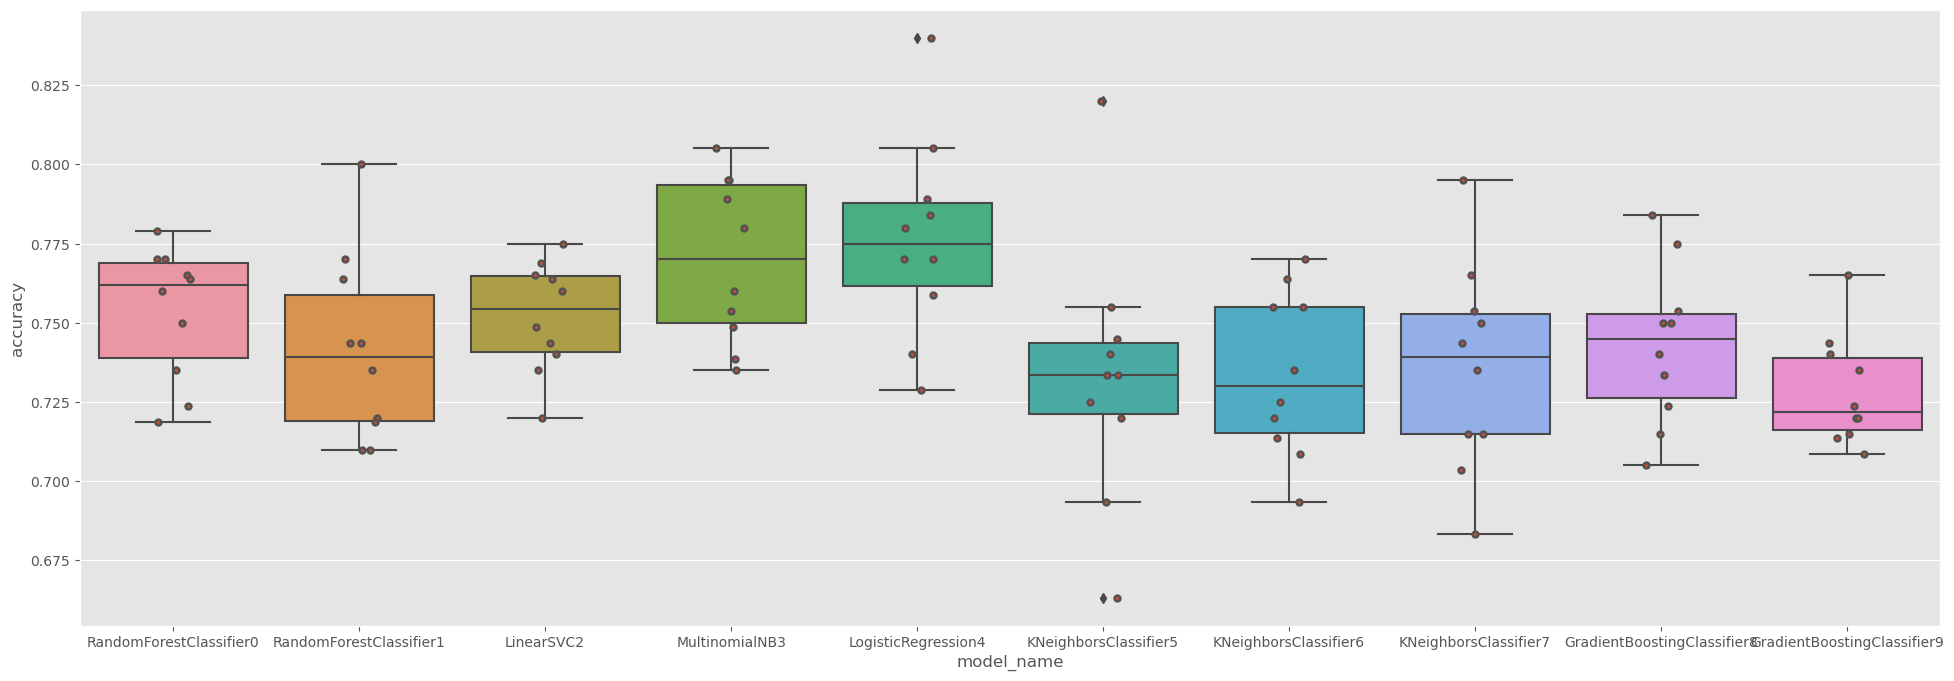

In [15]:
# Gráfica de accuracy de los modelos
figsize=(24,8)

plt.rcParams['figure.figsize'] = figsize

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=4, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [16]:
# Accuracy de los modelos
cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False)

model_name
LogisticRegression4            0.776530
MultinomialNB3                 0.770015
RandomForestClassifier0        0.753492
LinearSVC2                     0.752013
GradientBoostingClassifier8    0.742997
RandomForestClassifier1        0.741485
KNeighborsClassifier7          0.735942
KNeighborsClassifier6          0.733940
KNeighborsClassifier5          0.732912
GradientBoostingClassifier9    0.728445
Name: accuracy, dtype: float64

## LogisticRegression

In [17]:
models = [

    LogisticRegression(random_state=0,solver="lbfgs"),
    LogisticRegression(random_state=0,solver="liblinear"),
    LogisticRegression(random_state=0,solver="newton-cg"),
    LogisticRegression(random_state=0,solver="newton-cholesky"),
    LogisticRegression(random_state=0,solver="sag"),
    LogisticRegression(random_state=0,solver="saga"),
]

#Cross-validation: 20-folds
CV = 20

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
a = 0
for model in models:
    model_name = model.__class__.__name__+str(a)
    a += 1
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV,n_jobs = 5)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

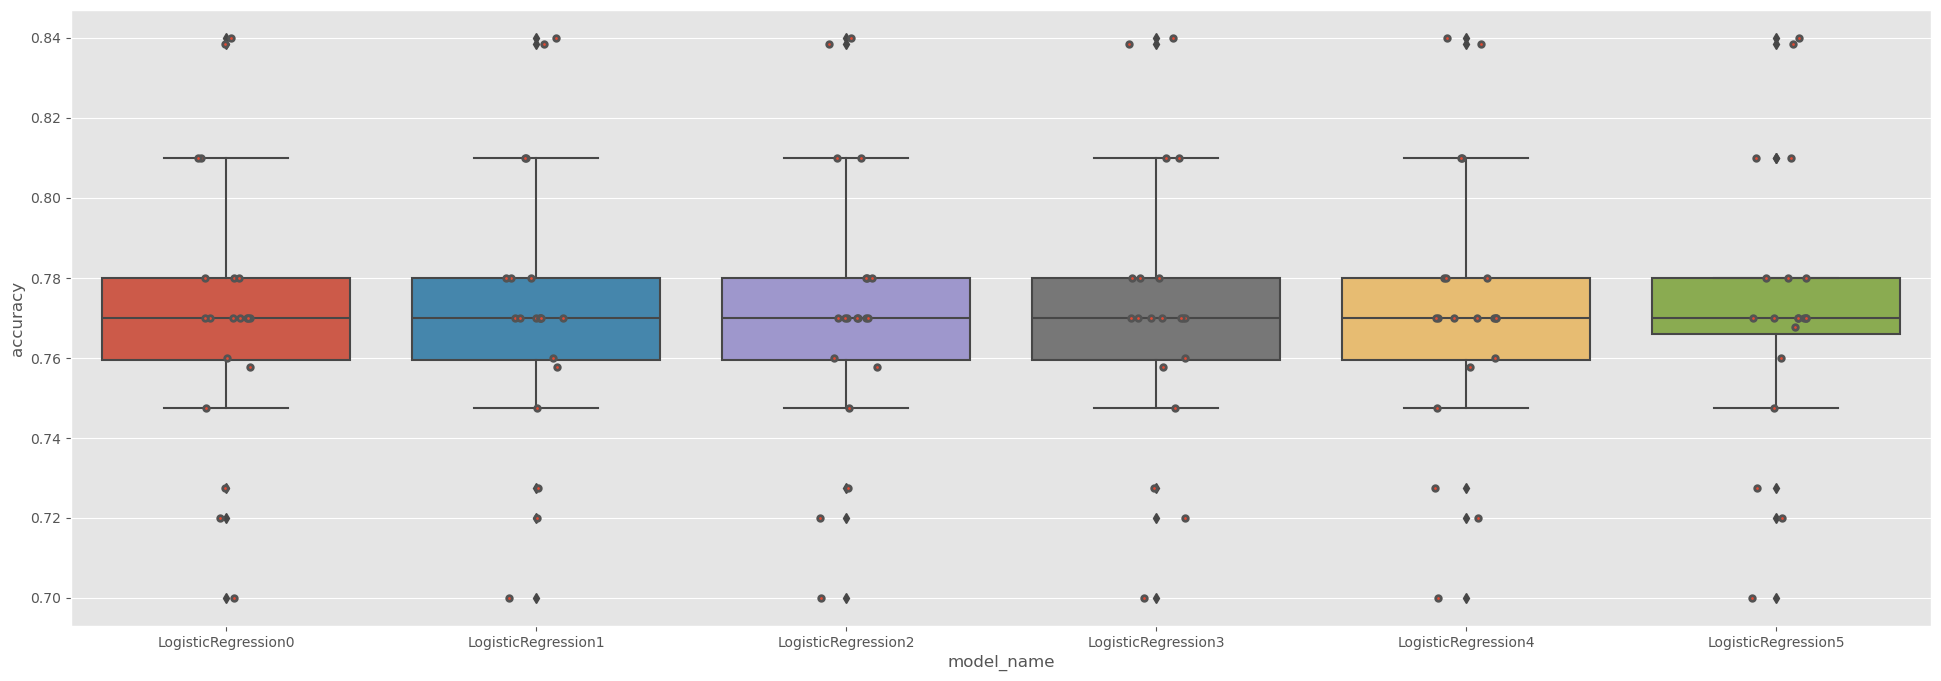

In [18]:
# Gráfica de accuracy de los modelos
figsize=(24,8)
plt.rcParams['figure.figsize'] = figsize
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=4, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [19]:

models = [
    LogisticRegression(random_state=0,solver="saga",penalty = "elasticnet", l1_ratio = 1),
    LogisticRegression(random_state=0,solver="saga",penalty = "elasticnet", l1_ratio = 0.6),
    LogisticRegression(random_state=0,solver="saga",penalty = "elasticnet", l1_ratio = 0.3),
    LogisticRegression(random_state=0,solver="saga",penalty = "elasticnet", l1_ratio = 0.1),
    LogisticRegression(random_state=0,solver="saga",penalty = "l1"),
    LogisticRegression(random_state=0,solver="saga",penalty = "l2"),
    LogisticRegression(random_state=0,solver="saga",penalty = None),
]

#Cross-validation: 20-folds
CV = 20

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
a = 0
for model in models:
    model_name = model.__class__.__name__+str(a)
    a += 1
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV,n_jobs = 5)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

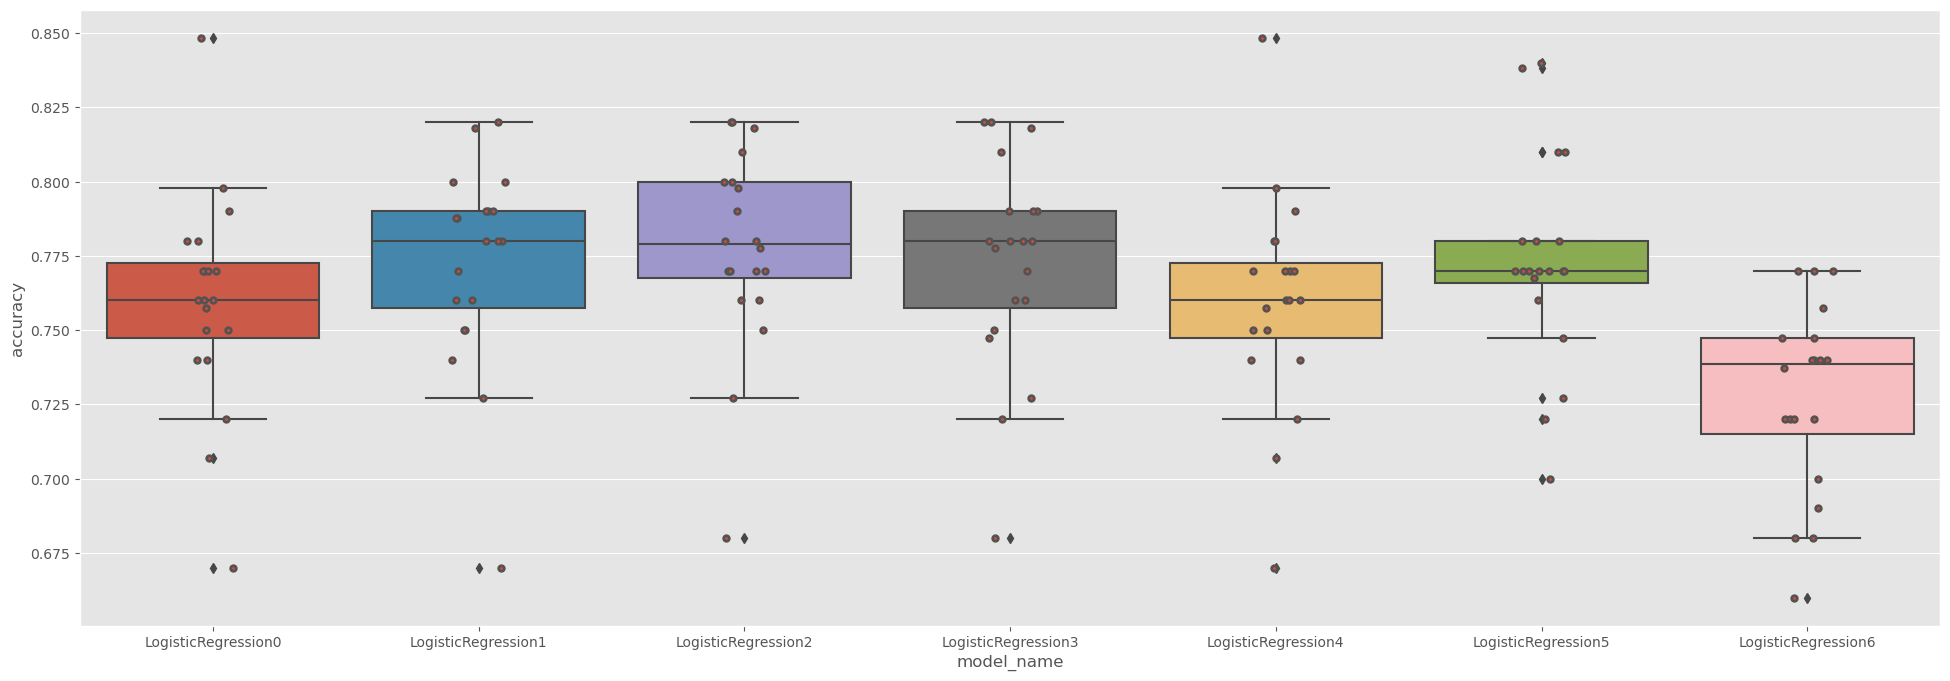

In [20]:
# Gráfica de accuracy de los modelos
figsize=(24,8)

plt.rcParams['figure.figsize'] = figsize

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=4, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [21]:
cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False)

model_name
LogisticRegression2    0.777561
LogisticRegression1    0.772561
LogisticRegression5    0.772540
LogisticRegression3    0.772535
LogisticRegression0    0.759556
LogisticRegression4    0.759556
LogisticRegression6    0.727495
Name: accuracy, dtype: float64

## RandomForestClassifier

In [22]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150, 200, 250],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 20, 50],
                 'criterion'   : ['gini', 'entropy']
                }
            )
CV = 10
scores = ['accuracy', 'f1', 'balanced_accuracy', 'precision', 'recall']
resultados = {'params': [], 'accuracy_mean': [], 'accuracy_std': [], 'f1_mean': [], 'f1_std': [], 'balanced_accuracy_mean': [], 'balanced_accuracy_std': [], 'precision_mean': [], 'precision_std': [], 'recall_mean': [], 'recall_std': []}

for params in param_grid:
    
    model = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    resultados['params'].append(params)
    for i in scores:
        print(f'evaluando con el score {i} con los params {params}')
        score_ = cross_val_score(model, features, labels, scoring=i, cv=CV,n_jobs = -1)

        desv = score_.std()
        mean = score_.mean()
        resultados[i+"_mean"].append(mean)
        resultados[i+"_std"].append(desv)


# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')

evaluando con el score accuracy con los params {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150}


evaluando con el score f1 con los params {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150}
evaluando con el score balanced_accuracy con los params {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150}
evaluando con el score precision con los params {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150}
evaluando con el score recall con los params {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150}
evaluando con el score accuracy con los params {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 200}
evaluando con el score f1 con los params {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 200}
evaluando con el score balanced_accuracy con los params {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 200}
evaluando con el score precision con los params {'criterion': 'gini', 'max_depth': None, 'max_featu

In [23]:
resultados

,accuracy_mean,accuracy_std,f1_mean,f1_std,balanced_accuracy_mean,balanced_accuracy_std,precision_mean,precision_std,recall_mean,recall_std,criterion,max_depth,max_features,n_estimators
0,0.772030,0.019480,0.771538,0.022574,0.772073,0.019479,0.780848,0.022414,0.763812,0.038607,gini,NaN,5,150
1,0.769033,0.021488,0.769960,0.023681,0.769032,0.021519,0.774982,0.027860,0.766832,0.040715,gini,NaN,5,200
2,0.767543,0.026196,0.768003,0.027051,0.767578,0.026253,0.775042,0.034063,0.762851,0.040320,gini,NaN,5,250
3,0.769028,0.024269,0.773016,0.026811,0.768846,0.024194,0.766806,0.023875,0.780693,0.044339,gini,NaN,7,150
4,0.772033,0.029271,0.774561,0.033684,0.771902,0.029119,0.771983,0.025461,0.778693,0.053504,gini,NaN,7,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.769000,0.030533,0.773101,0.032133,0.768867,0.030496,0.766781,0.032349,0.780673,0.044113,entropy,50.0,7,200
68,0.774030,0.023644,0.779245,0.024301,0.773837,0.023617,0.769134,0.026085,0.790634,0.036159,entropy,50.0,7,250
69,0.772038,0.022631,0.776596,0.024329,0.771867,0.022602,0.768272,0.020757,0.785683,0.034755,entropy,50.0,9,150
70,0.777558,0.024873,0.781481,0.025862,0.777407,0.024864,0.775217,0.024605,0.788673,0.037078,entropy,50.0,9,200


### Guardando resultados

In [24]:
resultados.to_csv("data/resultado.csv",index= False)

In [3]:
resultados = pd.read_csv("data/resultado.csv")

In [4]:
resultados.sort_values(by=['accuracy_mean'],ascending=False)

,accuracy_mean,accuracy_std,f1_mean,f1_std,balanced_accuracy_mean,balanced_accuracy_std,precision_mean,precision_std,recall_mean,recall_std,criterion,max_depth,max_features,n_estimators
35,0.779058,0.030277,0.784425,0.031630,0.778822,0.030239,0.772700,0.029170,0.797584,0.044646,gini,50.0,9,250
26,0.778548,0.028690,0.781890,0.030984,0.778433,0.028605,0.776614,0.024577,0.787644,0.040393,gini,20.0,9,250
70,0.777558,0.024873,0.781481,0.025862,0.777407,0.024864,0.775217,0.024605,0.788673,0.037078,entropy,50.0,9,200
29,0.777545,0.020443,0.780911,0.024728,0.777407,0.020317,0.775978,0.020615,0.787653,0.046194,gini,50.0,5,250
71,0.777048,0.022038,0.781011,0.023650,0.776902,0.021993,0.774711,0.024117,0.788683,0.039500,entropy,50.0,9,250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,0.730955,0.015798,0.762591,0.014977,0.729692,0.015615,0.687962,0.015599,0.856178,0.029054,gini,3.0,9,200
45,0.718432,0.024148,0.750867,0.022933,0.717191,0.024068,0.679121,0.023734,0.841277,0.042992,entropy,3.0,5,150
9,0.717937,0.020601,0.749667,0.019958,0.716731,0.020661,0.679589,0.020144,0.837337,0.039799,gini,3.0,5,150
46,0.714437,0.028575,0.750793,0.026912,0.713081,0.028373,0.671487,0.025431,0.853228,0.048367,entropy,3.0,5,200


In [8]:
resultados[["accuracy_mean","accuracy_std","criterion","max_depth","max_features","n_estimators"]].sort_values(by=['accuracy_mean'],ascending=False).head(10)

,accuracy_mean,accuracy_std,criterion,max_depth,max_features,n_estimators
35,0.779058,0.030277,gini,50.0,9,250
26,0.778548,0.028690,gini,20.0,9,250
70,0.777558,0.024873,entropy,50.0,9,200
29,0.777545,0.020443,gini,50.0,5,250
71,0.777048,0.022038,entropy,50.0,9,250
6,0.777043,0.019824,gini,NaN,9,150
7,0.775053,0.023208,gini,NaN,9,200
56,0.775035,0.029474,entropy,20.0,5,250
24,0.774525,0.033461,gini,20.0,9,150
41,0.774033,0.021833,entropy,NaN,7,250


# Modelo final

In [5]:
df = pd.read_csv('data/AmazonPreprocessed.csv')
particion = (100-25)/100
X_train, X_test, y_train, y_test = train_test_split(df['reseña'],df['clasificacion'], test_size=particion, random_state=42)
df = pd.concat([y_train, X_train], axis=1)
particion = (100-10)/100
len(df.index)



998437

In [6]:

X_train, X_test, y_train, y_test = train_test_split(df['reseña'],df['clasificacion'], test_size=particion, random_state=69)

## Entrenamiento

In [7]:
vectorizer = load_vectorizer()

labels = y_train
features = vectorizer.transform(X_train)

print("vectoricer done")

Final_model = RandomForestClassifier(
            oob_score    = True,
            n_jobs       = -1,
            random_state = 123,
            criterion = "gini",
            max_depth = None,
            max_features = 9,
            n_estimators = 100
            )

Final_model.fit(features,labels)



vectoricer done


RandomForestClassifier(max_features=9, n_jobs=-1, oob_score=True,
                       random_state=123)

In [53]:
with open("Modelo_Final_Clasificacion.pkl", 'wb') as file:
        pickle.dump(Final_model, file)

In [8]:

y_test_predict = Final_model.predict(vectorizer.transform(X_test))

In [11]:
y_test = y_test-1
y_test_predict = y_test_predict-1

In [34]:
np.unique(y_test_predict)

array([0, 1], dtype=int64)

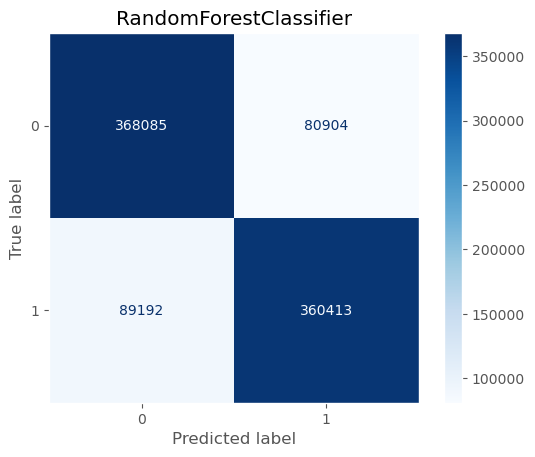

              precision    recall  f1-score   support

           0       0.80      0.82      0.81    448989
           1       0.82      0.80      0.81    449605

    accuracy                           0.81    898594
   macro avg       0.81      0.81      0.81    898594
weighted avg       0.81      0.81      0.81    898594



In [35]:

cm = confusion_matrix(y_test, y_test_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

disp.plot(cmap='Blues')

plt.title("RandomForestClassifier")
plt.grid(False)
plt.show()
print(classification_report(y_test, y_test_predict))

In [63]:
len(y_test)

898594

In [73]:
val = "Be prepared to pump it up. Works great! Son loves the color and thinks he has the best ball on the team"
print(val)


Be prepared to pump it up. Works great! Son loves the color and thinks he has the best ball on the team


In [74]:
val = process(val)
print(val)

 be prepar to pump it up work great son love the color and think he has the best ball on the team


In [75]:
val = vectorizer.transform([val])
terms = vectorizer.get_feature_names_out()


In [76]:
print(val)
print(len(terms))

  (0, 612)	0.4854666208854177
  (0, 611)	0.2584008246452286
  (0, 546)	0.2970686891501632
  (0, 505)	0.43466183012198817
  (0, 323)	0.2653117666967371
  (0, 233)	0.24089644862944798
  (0, 98)	0.4395080697554143
  (0, 54)	0.3142955381487512
631


In [52]:
val = Final_model.predict(val)
print(val)

[2]


# Conclusiones

La calidad del modelo depende del metodo de vectorización y el dataset que se usa para crearlo.

El modelo no tiene la capacidad de identificar el sarcasmo

Pandas no es adecuado para procesar grandes volumenes de datos por su alto consumo de memoria.  

# Trabajos futuros

Implementar el metodo de vectorizacion en herramientas orientadas a big data, como Spark,
para aumentar el numero de palabras y agregar tuplas de estas, con el fin de mejorar el contexto